# Forward Feature Selection for Achievements

### Import dependencies

In [1]:
import pandas as pd
import os
import subscript.config as cn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import metrics
import numpy as np
from IPython.display import HTML
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

### Read in and prepare data

In [14]:
df = pd.read_csv(os.path.join(cn.clean_dir,'final_feature_categories.csv'), dtype = 'unicode')
player_cols =  ['Unnamed: 0','player','realm','gear_score','last_login',
            'time_since_login','status']
df = df.drop(player_cols, axis = 1)
dfc = pd.read_csv(os.path.join(cn.clean_dir,'6-13_achievement_list.csv'), dtype = 'unicode')
df = df[df.engagement.astype(float) != 1]
df_original = df.copy()
if id in df.columns.names:
    df = df.set_index('id')
print(np.unique(df.engagement))
df.head()

['0.0' '2.0']


,6,7,8,9,10,11,12,13,16,31,...,11018,11030,11043,11056,12037,12197,13643,1412,1416,id
0,Character,Character,Character,Character,Character,Character,Character,Character,none,none,...,none,none,none,none,none,none,none,none,none,airgeyser_proudmoore
3,Character,Character,Character,Character,Character,Character,Character,Character,none,Quests,...,none,none,none,none,none,none,none,none,none,tharivool_proudmoore
5,Character,Character,Character,Character,Character,Character,Character,Character,none,Quests,...,none,none,none,none,none,none,none,none,none,yareij_proudmoore
6,Character,Character,Character,Character,Character,Character,Character,Character,none,none,...,none,none,none,none,none,none,none,none,none,oretenbro_proudmoore
7,Character,Character,Character,Character,Character,Character,Character,Character,none,Quests,...,none,none,none,none,none,none,none,none,none,connorpriest_proudmoore


## Convert any completed achievement to the category_id, else 0

In [17]:
#df = df_original.copy()
categories = ['Alterac Valley','Arathi Basin','Archaeology',
              'Arena','Argent Tournament','Ashran','Battle Dungeon',
              'Battle Raid','Battle for Azeroth','Battle for Gilneas',
              'Battlegrounds',"Brawler's Guild",'Brewfest','Cataclysm',
              'Cataclysm Dungeon','Cataclysm Raid','Character',
              "Children's Week",'Classic','Collections','Cooking',
              'Currencies','Darkmoon Faire','Deepwind Gorge','Draenor',
              'Draenor Dungeon','Draenor Garrison','Draenor Raid',
              'Dungeons','Dungeons & Raids','Eastern Kingdoms',
              'Events','Expansion Features','Exploration',
              'Eye of the Storm','Feats of Strength','Fishing',
              'General','Guild Feats of Strength',"Hallow's End",
              'Heart of Azeroth','Honor','Island Expeditions',
              'Isle of Conquest','Kalimdor','Legacy','Legion',
              'Legion Class Hall','Legion Dungeon','Legion Raid',
              'Lich King Dungeon','Lich King Raid','Love is in the Air',
              'Lunar Festival','Midsummer','Mounts','Noblegarden',
              'Northrend','Outland','Pandaria','Pandaria Dungeon',
              'Pandaria Raid','Pandaria Scenarios','Pet Battles',
              "Pilgrim's Bounty",'Player vs. Player','Professions',
              'Promotions','Quests','Raids','Rated Battleground',
              'Reputation','Seething Shore','Silvershard Mines',
              'Temple of Kotmogu','The Burning Crusade','Tol Barad',
              'Twin Peaks',"Visions of N'Zoth",'War Effort',
              'Warsong Gulch','Winter Veil','Wintergrasp','World',
              'World Events','Wrath of the Lich King']
xform = [c for c in df.columns.values if 'engagement' not in c and 'id' not in c]
df[xform] = df[xform].replace('none', '0')
for i,c in enumerate(categories):
    print(i, c, end = ' ')
    df[xform] = df[xform].replace(c,str(i))

df.head()

0 Alterac Valley 1 Arathi Basin 2 Archaeology 3 Arena 4 Argent Tournament 5 Ashran 6 Battle Dungeon 7 Battle Raid 8 Battle for Azeroth 9 Battle for Gilneas 10 Battlegrounds 11 Brawler's Guild 12 Brewfest 13 Cataclysm 14 Cataclysm Dungeon 15 Cataclysm Raid 16 Character 17 Children's Week 18 Classic 19 Collections 20 Cooking 21 Currencies 22 Darkmoon Faire 23 Deepwind Gorge 24 Draenor 25 Draenor Dungeon 26 Draenor Garrison 27 Draenor Raid 28 Dungeons 29 Dungeons & Raids 30 Eastern Kingdoms 31 Events 32 Expansion Features 33 Exploration 34 Eye of the Storm 35 Feats of Strength 36 Fishing 37 General 38 Guild Feats of Strength 39 Hallow's End 40 Heart of Azeroth 41 Honor 42 Island Expeditions 43 Isle of Conquest 44 Kalimdor 45 Legacy 46 Legion 47 Legion Class Hall 48 Legion Dungeon 49 Legion Raid 50 Lich King Dungeon 51 Lich King Raid 52 Love is in the Air 53 Lunar Festival 54 Midsummer 55 Mounts 56 Noblegarden 57 Northrend 58 Outland 59 Pandaria 60 Pandaria Dungeon 61 Pandaria Raid 62 Pand

,6,7,8,9,10,11,12,13,16,31,...,11018,11030,11043,11056,12037,12197,13643,1412,1416,id
0,16,16,16,16,16,16,16,16,0,0,...,0,0,0,0,0,0,0,0,0,airgeyser_proudmoore
3,16,16,16,16,16,16,16,16,0,68,...,0,0,0,0,0,0,0,0,0,tharivool_proudmoore
5,16,16,16,16,16,16,16,16,0,68,...,0,0,0,0,0,0,0,0,0,yareij_proudmoore
6,16,16,16,16,16,16,16,16,0,0,...,0,0,0,0,0,0,0,0,0,oretenbro_proudmoore
7,16,16,16,16,16,16,16,16,0,68,...,0,0,0,0,0,0,0,0,0,connorpriest_proudmoore


#### Intermediate save since the above step took a while

In [18]:
df.to_csv(os.path.join(cn.clean_dir,'final_achievement_category_id_2_groups.csv'), index = False)

#### Intermediate step to reload the converted dataframe (if needed)

In [21]:
df = pd.read_csv(os.path.join(cn.clean_dir,'final_achievement_category_id_2_groups.csv'), dtype = 'unicode')
df = df.set_index('id')
df.head()

,6,7,8,9,10,11,12,13,16,31,...,10114,11018,11030,11043,11056,12037,12197,13643,1412,1416
id,,,,,,,,,,,,,,,,,,,,,
airgeyser_proudmoore,16,16,16,16,16,16,16,16,0,0,...,0,0,0,0,0,0,0,0,0,0
tharivool_proudmoore,16,16,16,16,16,16,16,16,0,68,...,0,0,0,0,0,0,0,0,0,0
yareij_proudmoore,16,16,16,16,16,16,16,16,0,68,...,0,0,0,0,0,0,0,0,0,0
oretenbro_proudmoore,16,16,16,16,16,16,16,16,0,0,...,0,0,0,0,0,0,0,0,0,0
connorpriest_proudmoore,16,16,16,16,16,16,16,16,0,68,...,0,0,0,0,0,0,0,0,0,0


## Convert any remaining dates to 1s (a few don't have categories)

In [22]:
for col in df.columns.values:
    if df[col].str.contains('20').any() == True:
        df[col] = np.where(df[col] != '0','9999',df[col])

## Make Training and Test Sets
Dataset is imbalanced, so I'm using stratified shuffle split to ensure the test and train sets have the same proportions of active, at-risk, and lapsed users.

In [45]:
if id in df.columns.names:
    df = df.set_index('id')
try:
    df = df.drop('id', axis = 1)
except:
    pass

df = df[df.engagement.astype(float) != 1].astype(float)
split = StratifiedShuffleSplit(n_splits = 10, test_size = 0.25, random_state = 17)
for train_index, test_index in split.split(df, df.engagement):
    strat_train = df.iloc[train_index][:]
    strat_test = df.iloc[test_index][:]

y_train = strat_train.engagement
X_train = strat_train.drop('engagement', axis = 1)
y_test = strat_test.engagement
X_test = strat_test.drop('engagement', axis = 1)

In [46]:
print(X_train.shape, X_test.shape)

(57561, 4013) (19187, 4013)


(array([18045.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  1142.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

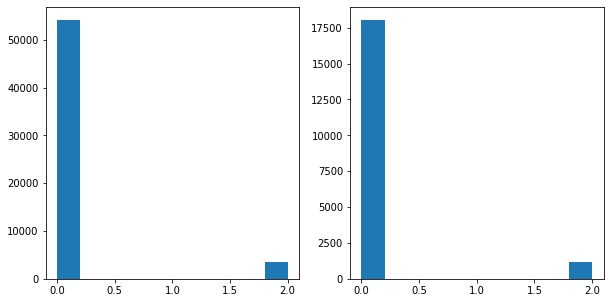

In [47]:
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].hist(strat_train.engagement)
ax[1].hist(strat_test.engagement)

## Run the Random Forest Classifier for Feature Selection
Tried weapper method, but with 1000 features, even one comparison was not done after 2 hours.
Doing regular feature selection with random forest 
Not weighted because I grouped At-Risk and Lapsed users

In [48]:
class_weight = dict({0:21})
feature_selector = RandomForestClassifier(n_jobs=-1, 
            class_weight = class_weight, bootstrap=True,
            n_estimators=200,
            oob_score=True,random_state=17)
features = feature_selector.fit(np.array(X_train), y_train)


In [49]:
print(X_train.shape, X_test.shape)

(57561, 4013) (19187, 4013)


#### Get Feature Importances

In [50]:
importances = feature_selector.feature_importances_
indices = np.argsort(importances)
important_features = X_train.columns.values[indices]

In [57]:
dfc = pd.read_csv(os.path.join(cn.clean_dir,'6-13_achievement_list.csv'), dtype = 'unicode')
df_pred = pd.DataFrame({'important_features': important_features})
df_pred['name'] = ''
df_pred['category'] = ''
for index, row in df_pred.iterrows():
    df_pred.at[index,'name'] = dfc[dfc.achievement_id == row.important_features].achievement_name.to_string(index = False)
    df_pred.at[index,'category'] = dfc[dfc.achievement_id == row.important_features].category_name.to_string(index = False)
df_pred.to_csv(os.path.join(cn.clean_dir, 'random_forest_features','binary_achievement_importances.csv'), index = False)
display(HTML(df_pred.to_html()))

,important_features,name,category
0,1164,Everything Counts,Alterac Valley
1,9995,Soldier of the Alliance: Warlords Season 1,Player vs. Player
2,9996,Defender of the Alliance: Warlords Season 1,Player vs. Player
3,9997,Guardian of the Alliance: Warlords Season 1,Player vs. Player
4,9998,Soldier of the Horde: Warlords Season 1,Player vs. Player
5,10000,Guardian of the Horde: Warlords Season 1,Player vs. Player
6,10001,Defender of the Horde: Warlords Season 1,Player vs. Player
7,873,Frostwolf Perfection,Alterac Valley
8,10069,"I Came, I Clawed, I Conquered",Draenor
9,10096,Wild Gladiator: Warlords Season 2,Player vs. Player


These results are unexpected, but I've replicated them by classifying features in all three groups and in two groups. Those players who complete the most difficult and time-consuming content are likely to keep playing across expansions. This reiterates the time series classification resutls in which the likelihood of a player continuing to be engaged is their long-term player history. World of Warcraft has a loyal subscriber base that makes up the bulk of its active players. 

Interestingly, the Player vs Player content is most popular among active players, likely due to the seasonal competitions that continue with or without release of new content. Close behind are achievements from past expansions, which is due in large part to the correlation of engagement status and subscriber loyalty, but is also the likely result of players repeating old content while waiting for new content. 

**In summary, seasonal player vs. player content and replayable world content are the most promising targets for future investment.**

#### Get the Out-of-Bag score

In [52]:
features.oob_score_

0.9830614478553187

#### Get Engagement Predictions Based on Achievements

In [53]:
predictions = feature_selector.predict(X_test)
df_pred = pd.DataFrame(X_test)
df_pred['prediction'] = predictions
df_pred['actual'] = y_test
df_pred.to_csv(os.path.join(cn.clean_dir, 'random_forest_features',
        'final_feature_predictions.csv'), index = False)

#### Get Confusion Matrix

In [54]:
met = metrics.classification_report(y_test, predictions, digits=3)
print(met)
cnf_matrix = metrics.confusion_matrix(y_test,predictions)
print(cnf_matrix)

              precision    recall  f1-score   support

         0.0      0.987     0.998     0.992     18045
         2.0      0.957     0.793     0.867      1142

    accuracy                          0.986     19187
   macro avg      0.972     0.896     0.930     19187
weighted avg      0.985     0.986     0.985     19187

[[18004    41]
 [  236   906]]


Plotting the confusion matrix...


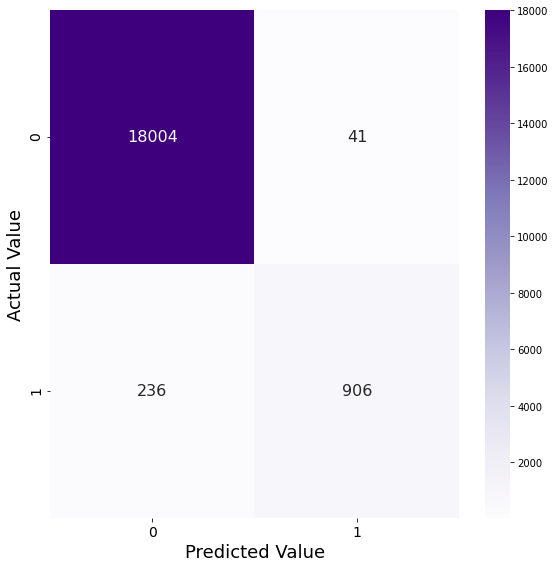

In [55]:
print("Plotting the confusion matrix...")
fig2, ax = plt.subplots(figsize = (8,8))
sns.heatmap(pd.DataFrame(cnf_matrix), annot = True, cmap = 'Purples', 
            fmt = 'g', annot_kws={"size":16})
ax.set_xlabel ("Predicted Value", fontsize = 18)
ax.set_ylabel ("Actual Value", fontsize = 18)
ax.tick_params (labelsize = 14)
plt.tight_layout()
fig2.savefig(os.path.join(cn.clean_dir, 'random_forest_features',
            'cnfmatrix_features.png'), dpi=180)


In [56]:
# save the model to disk
pickle_name = 'final_feature_model_3_groups.sav'
os.chdir(os.path.join(cn.clean_dir,'random_forest_features'))
with open(pickle_name, 'wb') as file:
    pickle.dump(features, file)
plt.show()